In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.v2 import GaussianNoise
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint_adjoint as odeint

In [105]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)
rtol = 1e-3
atol = 1e-3

In [106]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=rtol, atol=atol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)



In [107]:
downsampling_layers = [
nn.Conv2d(1, 64, 3, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
]
feature_layers = [ODEBlock(ODEfunc(64))]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
model = nn.Sequential(
    *downsampling_layers,
    *feature_layers,
    *fc_layers
)

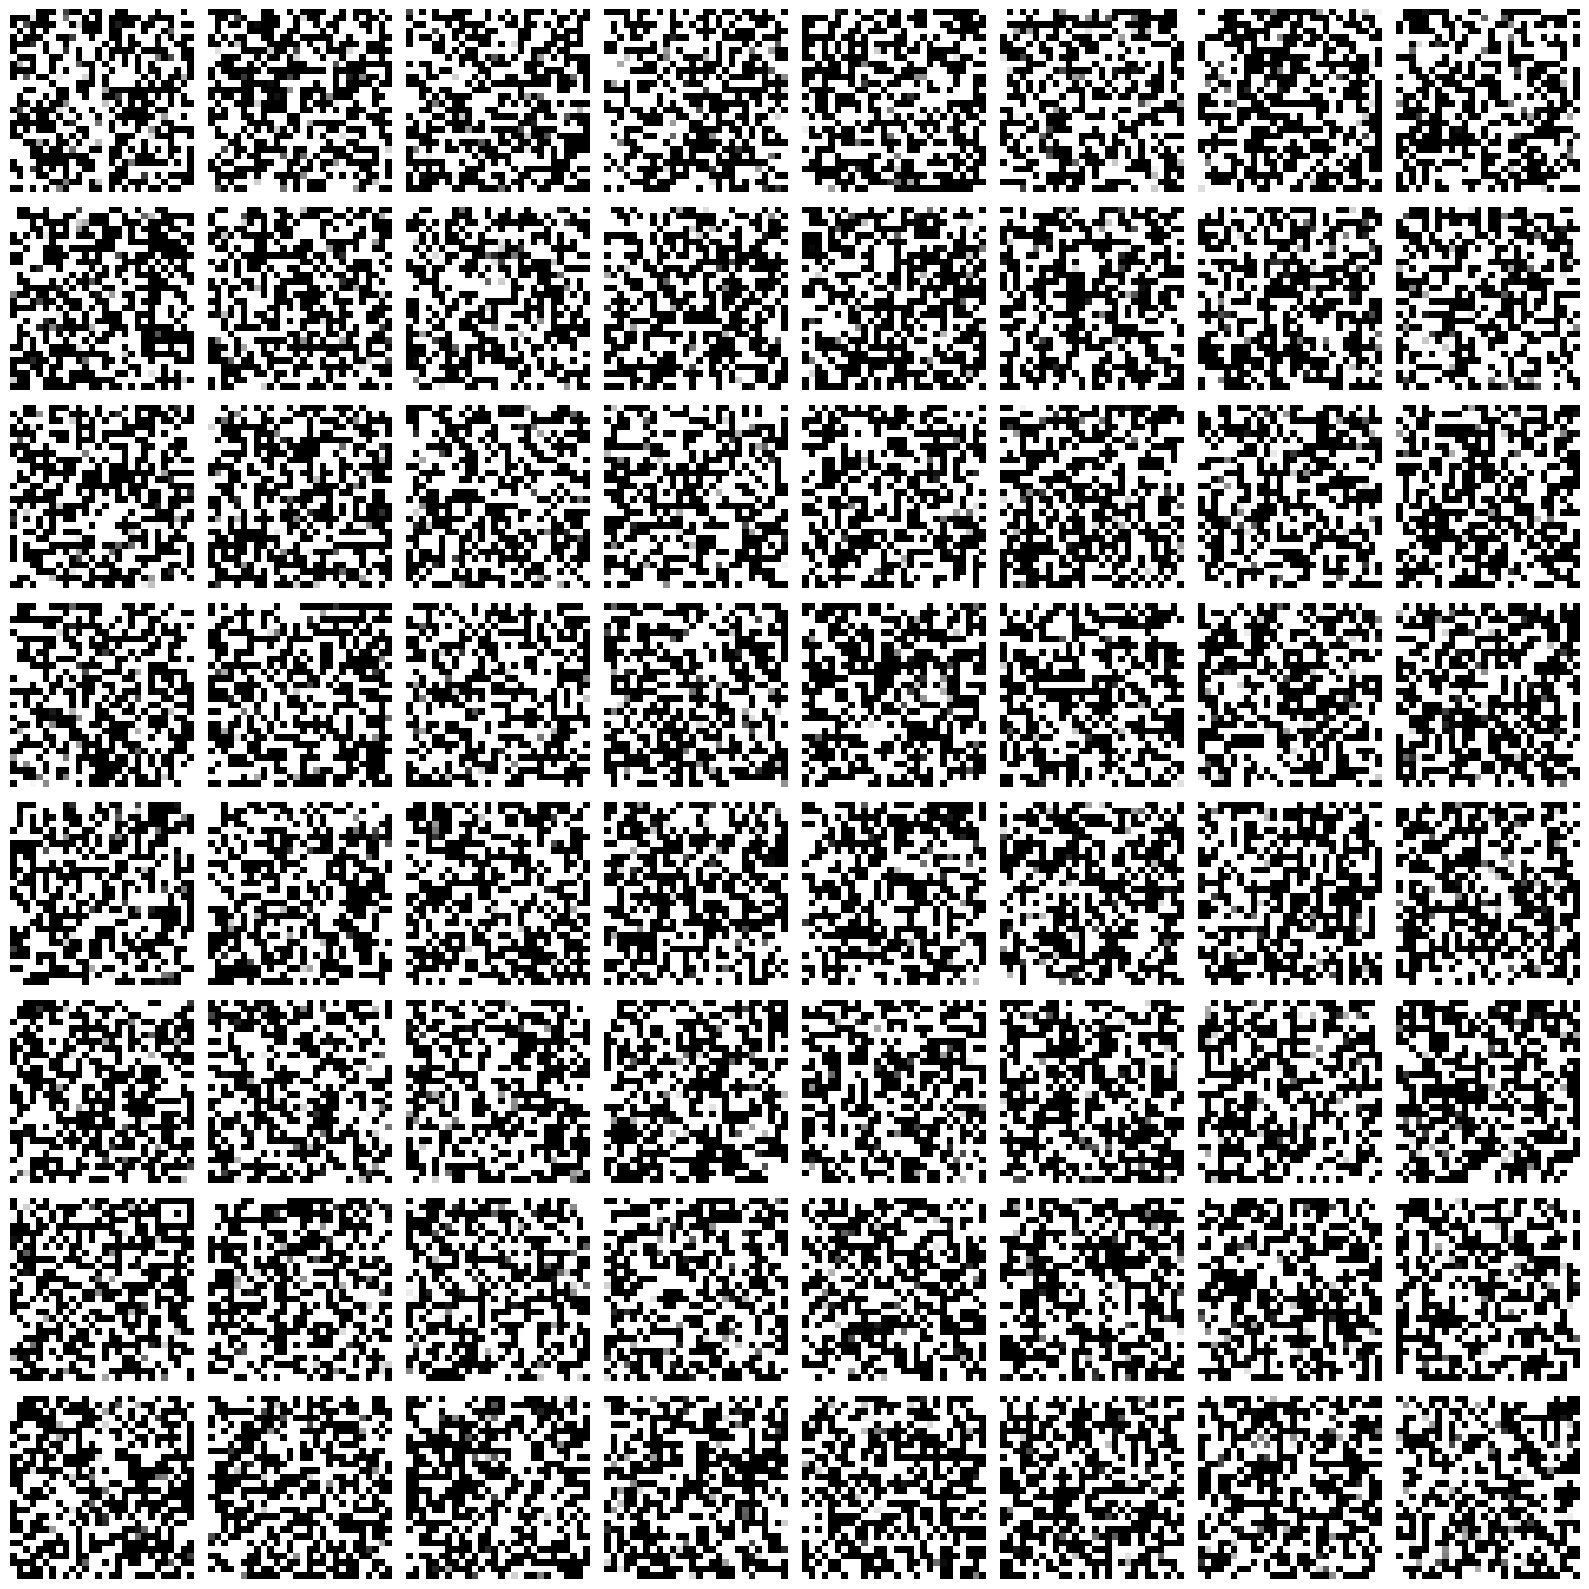

In [ ]:
transform = transforms.Compose([
transforms.RandomCrop(28, padding=4),
transforms.ToTensor(),
GaussianNoise(0.,1.),
])
mnist = datasets.MNIST(root='./.data/mnist', train=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)
def show_images(images, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(next(iter(dataloader))[0])

In [11]:
## Load model from experiment folder 

model_state_dict = torch.load('./experiment/model.pth',weights_only=False)
model.load_state_dict(model_state_dict['state_dict'])
# Set model to evaluation mode
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


Output: 3


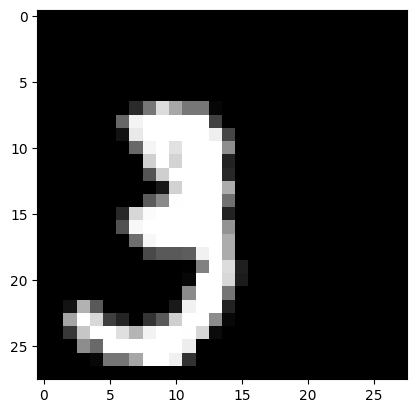

In [35]:
# Single evaluation of the model on a single image
k =7 
img_raw = mnist[10][0]
plt.imshow(img_raw.squeeze(), cmap='gray')
with torch.no_grad():
    image = img_raw.unsqueeze(0)
    output = model(image)
    output = output.argmax(dim=1).item()
    print("Output:", output)


In [42]:
def ode_test(model, img_raw, n_samples=10):
    initial_layers = list(model.children())[:7]
    ode_layer = list(model.children())[7]
    later_model = nn.Sequential(*list(model.children())[8:])
    initial_layers = nn.Sequential(*initial_layers)
    ts = torch.linspace(0.1, 1, n_samples).float()
    for t in ts:
        with torch.no_grad():
            image = img_raw.unsqueeze(0)
            image = initial_layers(image)
            ode_layer.integration_time = torch.tensor([0, t]).float().to(image.device)
            image = ode_layer(image)
            image = later_model(image)
            output = image.argmax(dim=1).item()
            print(f"t={t.item():.2f}, Output: {output}")

In [82]:
for k in dataloader:
    print(k)

KeyboardInterrupt: 

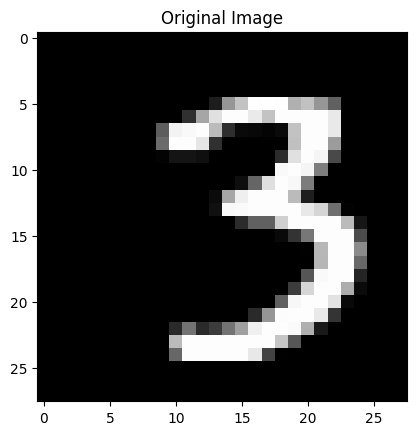

t=0.10, Output: 5
t=0.11, Output: 5
t=0.12, Output: 5
t=0.13, Output: 5
t=0.14, Output: 5
t=0.15, Output: 5
t=0.15, Output: 5
t=0.16, Output: 5
t=0.17, Output: 5
t=0.18, Output: 5
t=0.19, Output: 5
t=0.20, Output: 5
t=0.21, Output: 5
t=0.22, Output: 5
t=0.23, Output: 5
t=0.24, Output: 5
t=0.25, Output: 5
t=0.25, Output: 5
t=0.26, Output: 3
t=0.27, Output: 3
t=0.28, Output: 3
t=0.29, Output: 3
t=0.30, Output: 3
t=0.31, Output: 3
t=0.32, Output: 3
t=0.33, Output: 3
t=0.34, Output: 3
t=0.35, Output: 3
t=0.35, Output: 3
t=0.36, Output: 3
t=0.37, Output: 3
t=0.38, Output: 3
t=0.39, Output: 3
t=0.40, Output: 3
t=0.41, Output: 3
t=0.42, Output: 3
t=0.43, Output: 3
t=0.44, Output: 3
t=0.45, Output: 3
t=0.45, Output: 3
t=0.46, Output: 3
t=0.47, Output: 3
t=0.48, Output: 3
t=0.49, Output: 3
t=0.50, Output: 3
t=0.51, Output: 3
t=0.52, Output: 3
t=0.53, Output: 3
t=0.54, Output: 3
t=0.55, Output: 3
t=0.55, Output: 3
t=0.56, Output: 3
t=0.57, Output: 3
t=0.58, Output: 3
t=0.59, Output: 3
t=0.60, Ou

In [51]:
img_raw = mnist[10000][0]
plt.imshow(img_raw.squeeze(), cmap='gray')
plt.title("Original Image")
plt.show()
ode_test(model, img_raw, n_samples=100)

In [13]:
methods = ['dopri5', 'euler', 'rk4', 'explicit_adams','implicit_adams', 'bosh3','fehlberg2', 'euler','midpoint','dopri8','adaptive_heun']